# Custom Split Example

In [25]:
from pathlib import Path

from plinder.data.splits import (
    split,
    get_default_config,
)
from plinder.core.scores import query_index

### Split Config

First, let's modify the split config. We will first get the default config using `get_default_config()` and then change some of the parameters.

In [26]:
cfg = get_default_config() 
print(f'Validation set size: {cfg.split.num_val}')
print(f'Test set size: {cfg.split.num_test}')
print(f'Minimum size of each cluster in the validation set: {cfg.split.min_val_cluster_size}')

Validation set size: 1000
Test set size: 1000
Minimum size of each cluster in the validation set: 30


Since we reduced the total number of samples, let's also reduce the minimum validation set cluster size, so we avoid removing to many systems. <br> All configs can be found [here](https://plinder-org.github.io/plinder/dataset.html#splits-splits)

In [27]:
cfg.split.num_test = 500 # Reduce the max size of the test set
cfg.split.num_val = 500 # Reduce the max size of the validation set
cfg.split.min_val_cluster_size = 5 # Reduce the minimum required size of each cluster in the validation set

### Custom Dataset

Let's generate a custom dataset that we want to resplit. First, let's load the plindex and then create a custom dataset.

In [28]:
cols_of_interest = [
    "system_id",
    "entry_pdb_id",
    "ligand_ccd_code",
    "ligand_binding_affinity",
    "ligand_is_proper",
    "ligand_molecular_weight",
    "system_has_binding_affinity",
]
custom_df = query_index(
    columns=cols_of_interest, splits=["train", "val", "test", "removed"] 
)

2024-10-25 11:14:50,015 | plinder.core.utils.cpl.download_paths:24 | INFO : runtime succeeded: 0.53s
2024-10-25 11:14:51,601 | plinder.core.utils.cpl.download_paths:24 | INFO : runtime succeeded: 0.55s


In [29]:
custom_df.shape

(567394, 8)

Let's filter every system out that doesn't have a binding affinity `system_has_binding_affinity`, ions and artifacts `ligand_is_proper` and ligands with a molecular weight of less than 400 g/mol `ligand_molecular_weight`.

In [30]:
custom_df = custom_df[
    (custom_df["ligand_is_proper"] == True) &
    (custom_df["system_has_binding_affinity"] == True) &
    (custom_df["ligand_molecular_weight"] > 400)
]
custom_df.head(4)

,system_id,entry_pdb_id,ligand_ccd_code,ligand_binding_affinity,ligand_is_proper,ligand_molecular_weight,system_has_binding_affinity,split
20,2grt__1__1.A_2.A__1.C,2grt,GDS,6.079633,True,612.151962,True,train
22,2grt__1__1.A_2.A__2.C,2grt,GDS,6.079633,True,612.151962,True,train
74,8gr9__1__1.A_1.B__1.C_1.J,8gr9,COA,5.465907,True,767.115209,True,removed
85,1grn__1__1.A_1.B__1.C_1.D_1.E,1grn,GDP,3.428291,True,443.024330,True,train


In [31]:
custom_df.shape

(36247, 8)

In [32]:
custom_df['split'].value_counts()

split
train      25610
removed    10483
val           92
test          62
Name: count, dtype: int64

### Resplitting the Dataset

We see that we end up with only 92 systems in our validation set and 62 in our test set. We also have over 10k removed systems. Let's resplit the dataset and see how the new split looks like.

__NOTE__: resplitting the dataset requires a lot of memory and might only be feasible on a HPC cluster.

In [ ]:
data_dir = Path("~/.local/share/plinder/2024-06/v2")
custom_systems = set(custom_df['system_id'].unique())
split_name = 'custom_1'

new_split_df = split(
    data_dir=data_dir,
    cfg=cfg, # here we use the modified config from earlier
    relpath=split_name,
    selected_systems=custom_systems 
)
new_split_df.shape

(33047, 13)

In [34]:
new_split_df.head(4)

,system_id,uniqueness,split,cluster,cluster_for_val_split,system_pass_validation_criteria,system_pass_statistics_criteria,system_proper_num_ligand_chains,system_proper_num_pocket_residues,system_proper_num_interactions,system_proper_ligand_max_molecular_weight,system_has_binding_affinity,system_has_apo_or_pred
0,10gs__1__1.A_1.B__1.C,10gs__A_B__C_c101993,train,c62,c0,True,True,1,24,15,473.162057,True,False
1,10gs__1__1.A_1.B__1.E,10gs__A_B__E_c101949,train,c62,c0,True,True,1,24,13,473.162057,True,False
2,19gs__1__1.A_1.B__1.C_1.D,19gs__A_B__C_D_c147080,train,c62,c0,False,True,2,30,12,787.630334,True,False
3,19gs__1__1.A_1.B__1.F_1.G,19gs__A_B__F_G_c101954,train,c62,c0,False,True,2,30,14,787.630334,True,False


### Visualizing the new Split

Now that we have our first custom split, let's use the `SplitPropertiesPlotter` to visualize the new split.

In [ ]:
from plinder.core.split.plot import SplitPropertiesPlotter

In [ ]:
plotter = SplitPropertiesPlotter.from_files(
    data_dir = Path('~/.local/share/plinder/2024-06/v2'),
    split_file = Path(f'~/.local/share/plinder/2024-06/v2/splits/split_{split_name}.parquet'),
)

This will create a folder `split_plots` in the current working directory with the following plots:

`split_plots/split_proportions.png`

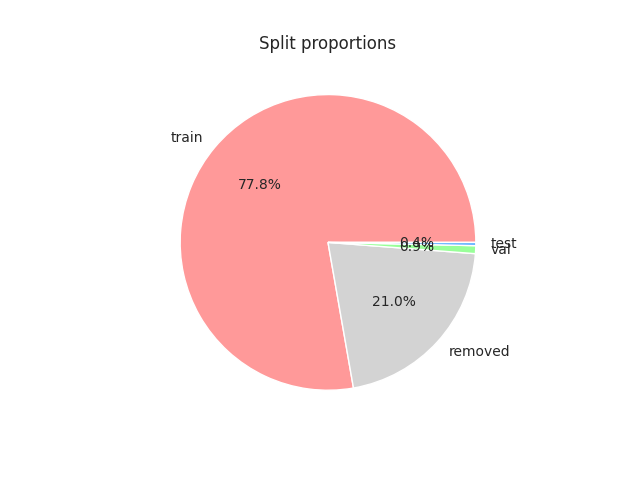

`split_plots/chain_composition.png`

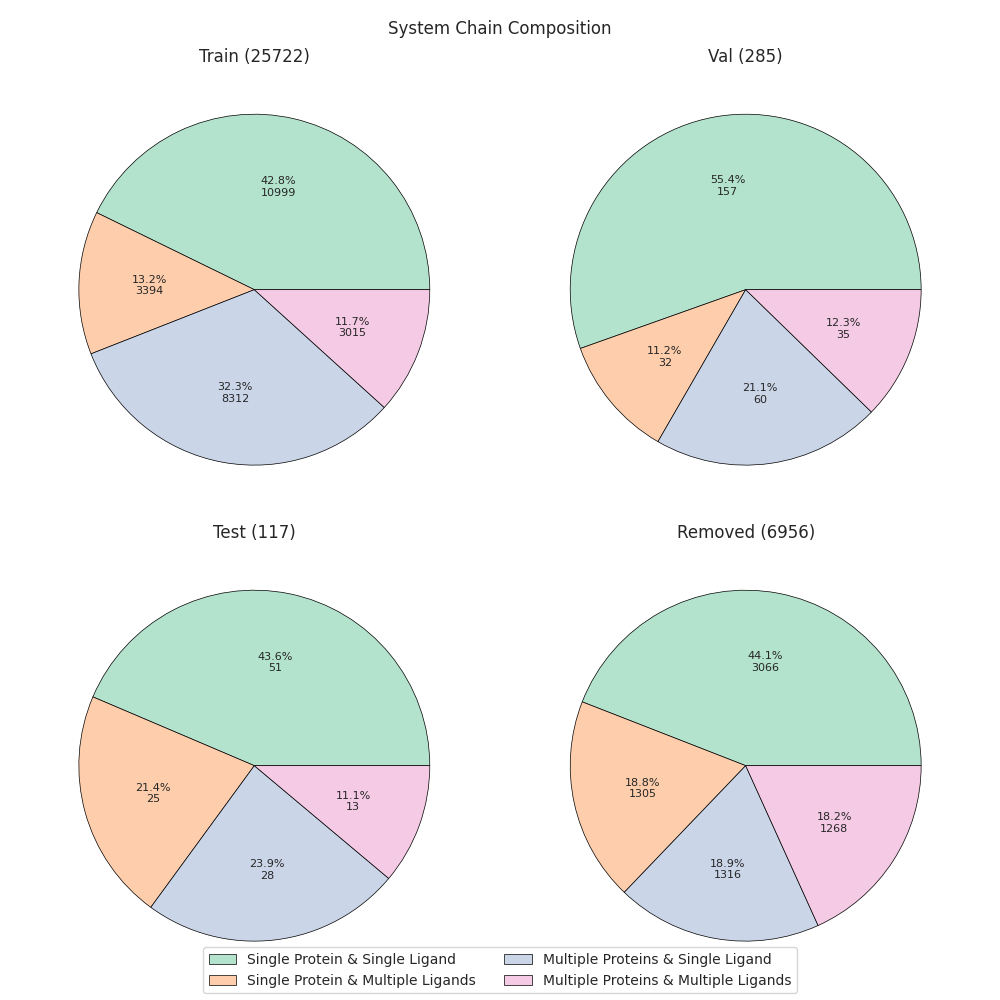

`split_plots/domain_classifications.png` 

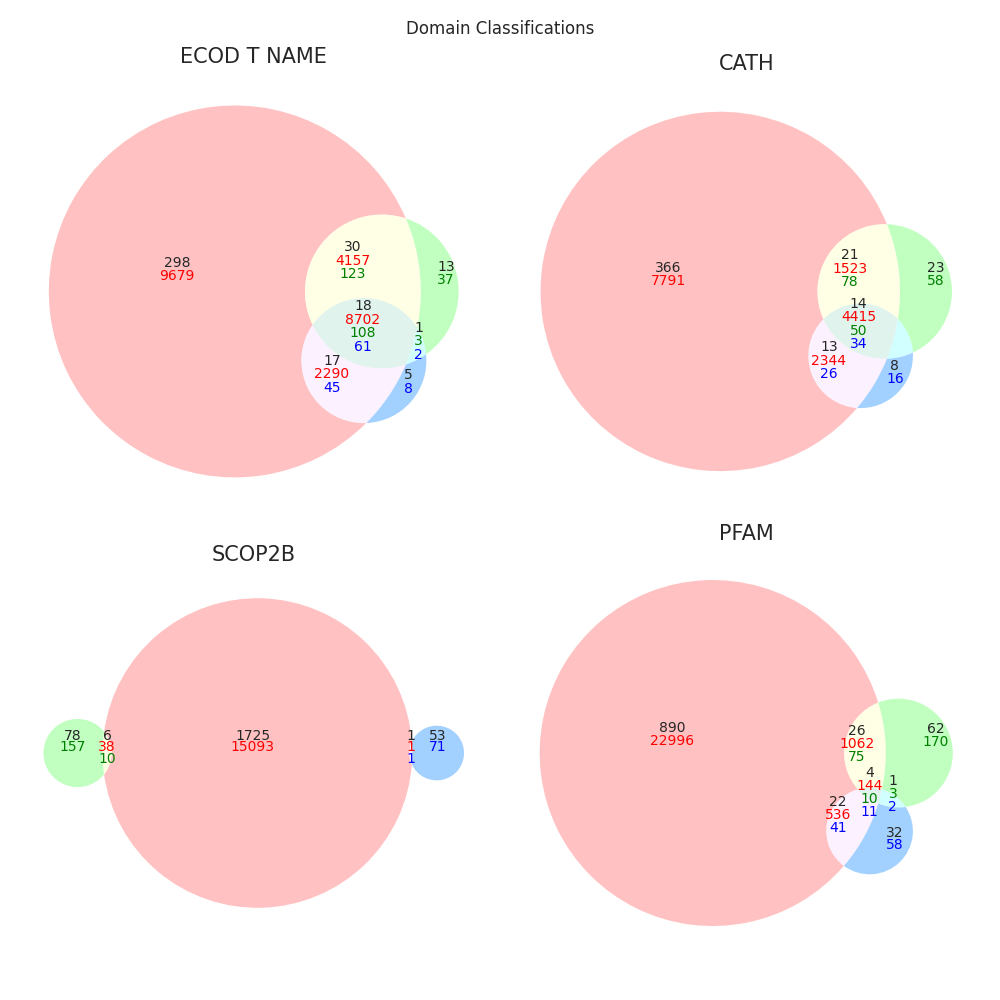

`split_plots/ligand_types.png` 

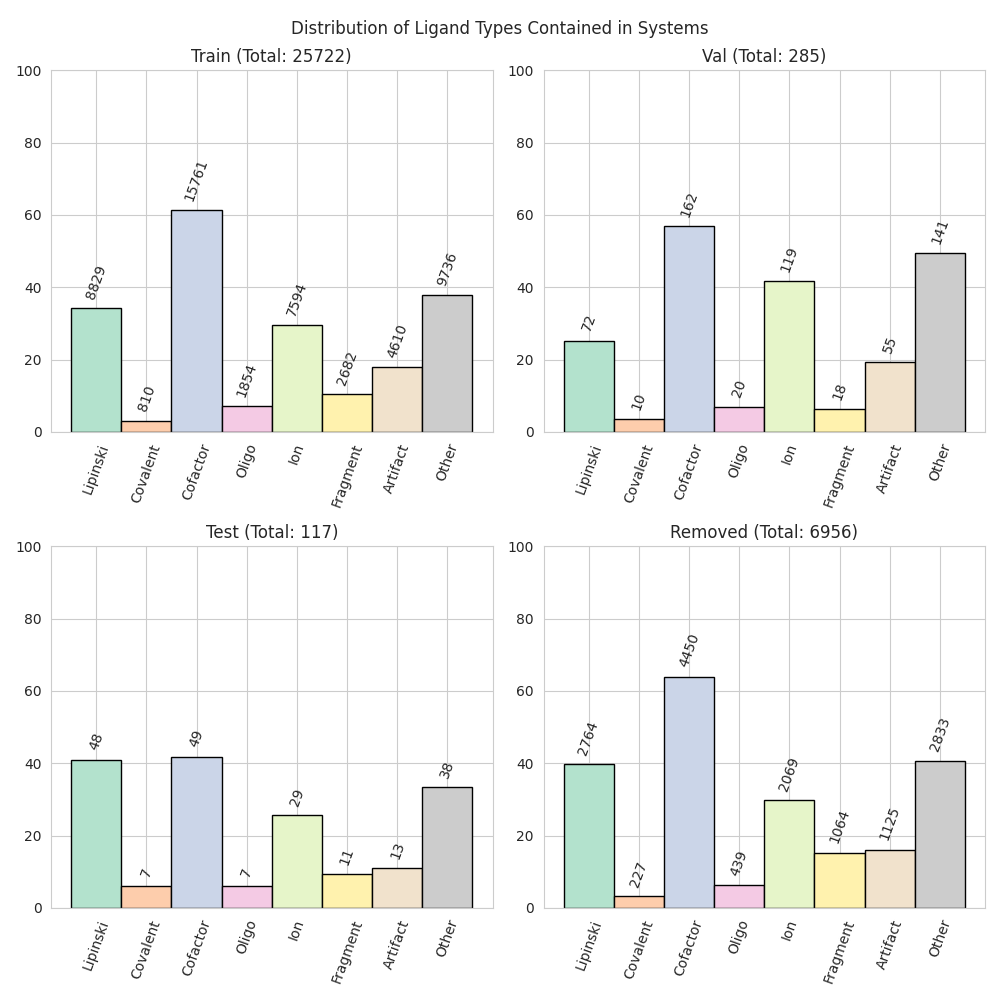

`split_plots/molecular_descriptors.png` 

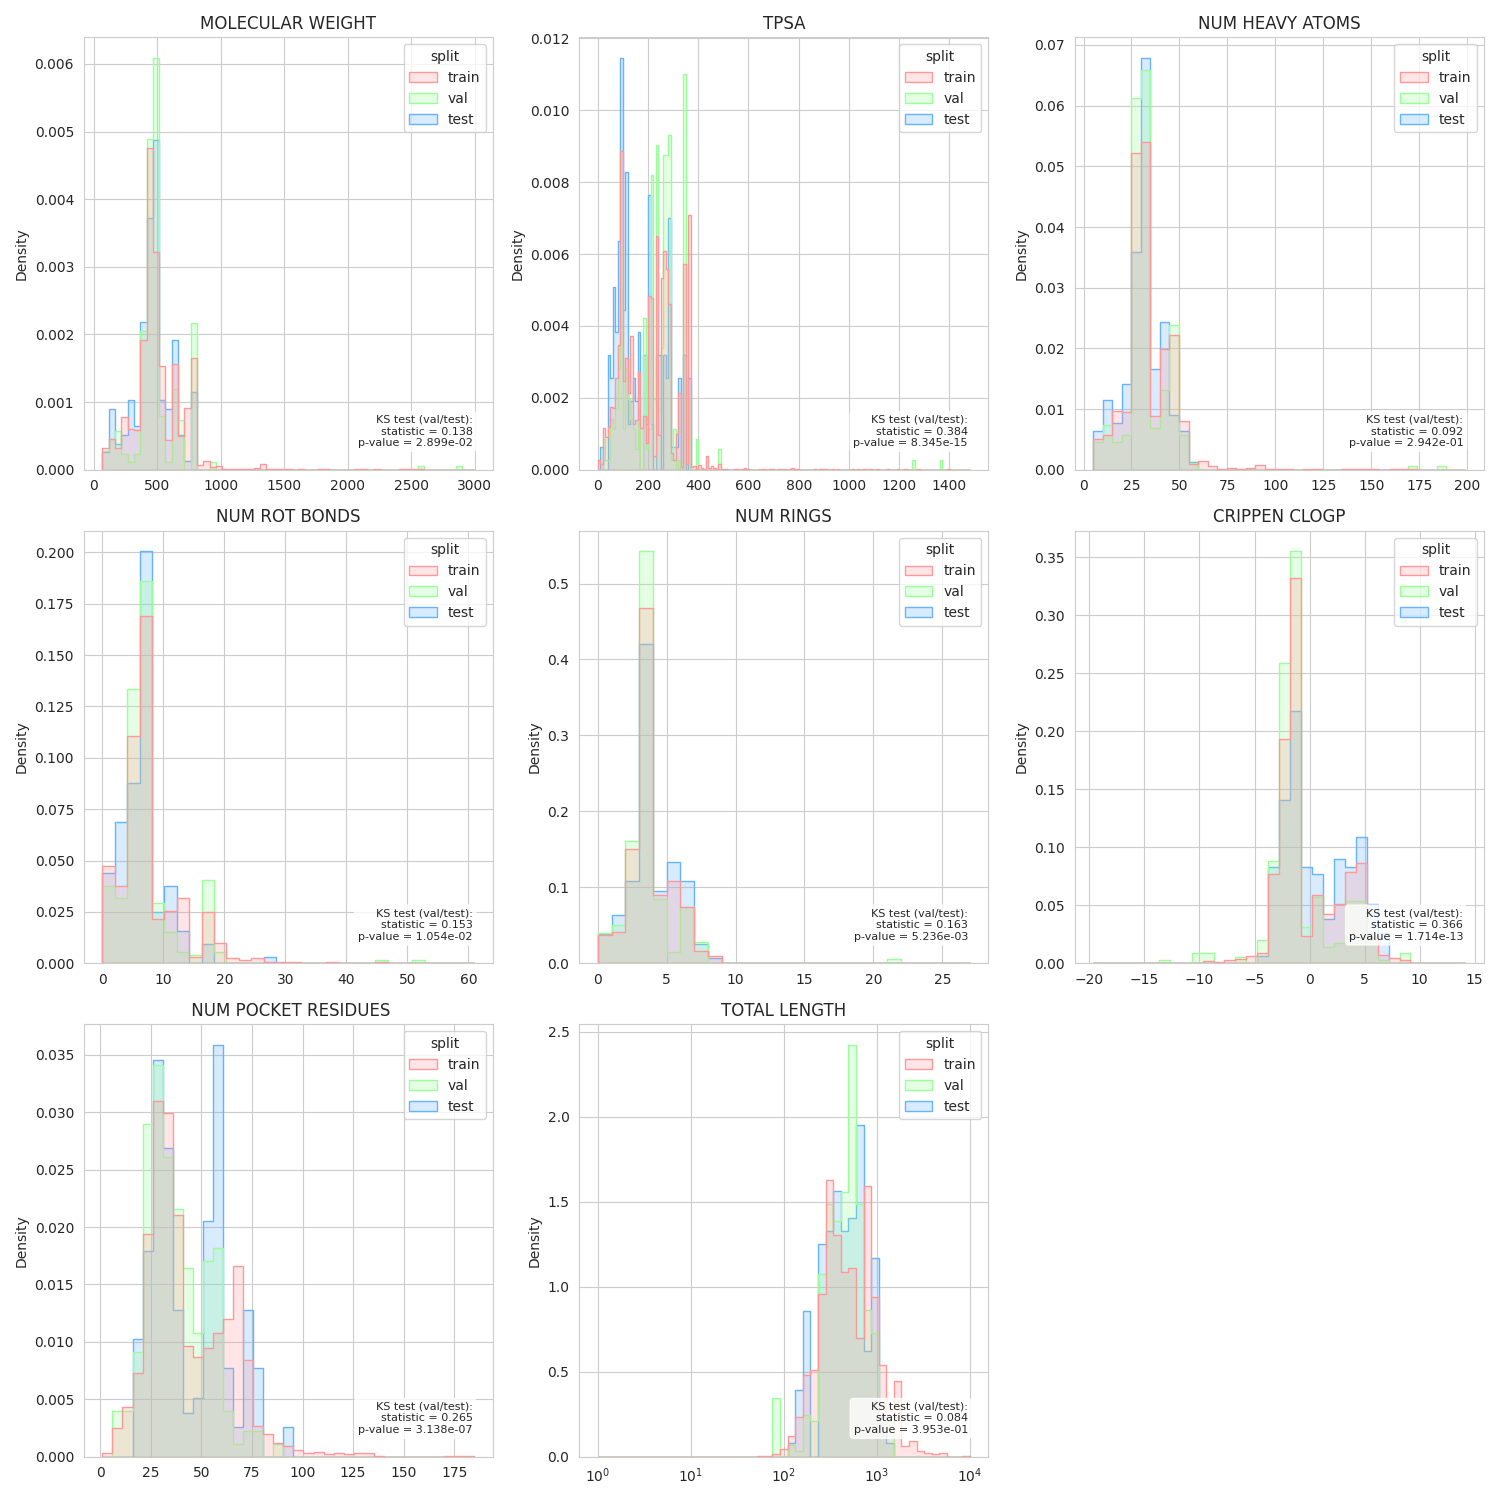

`split_plots/priorities.png`

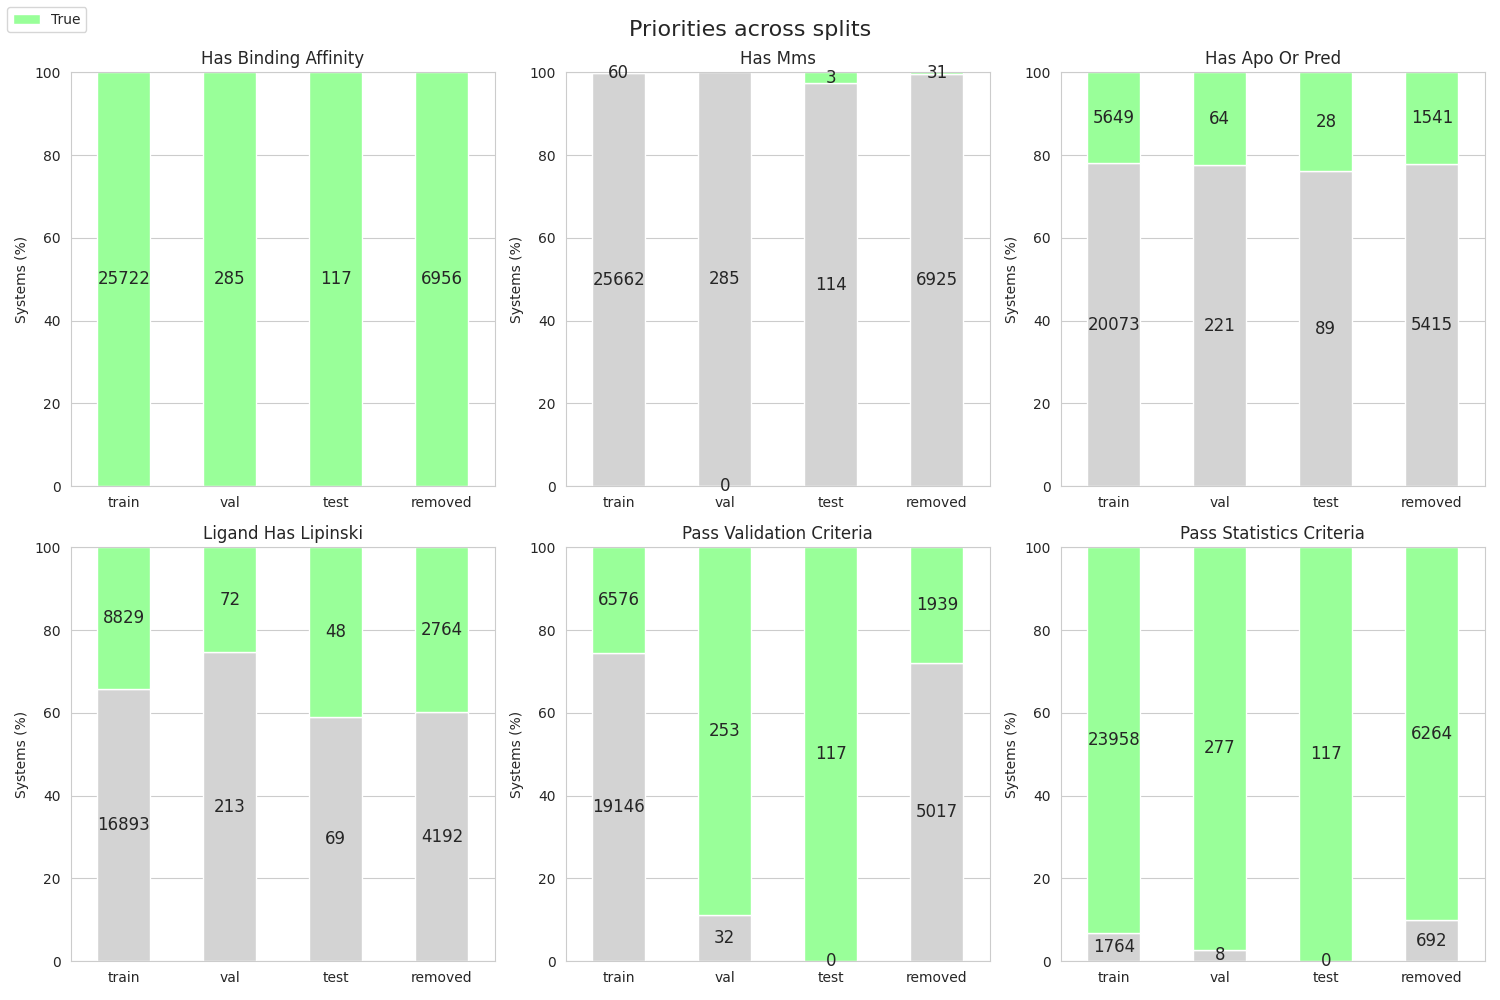

`split_plots/plinder_clusters.png`

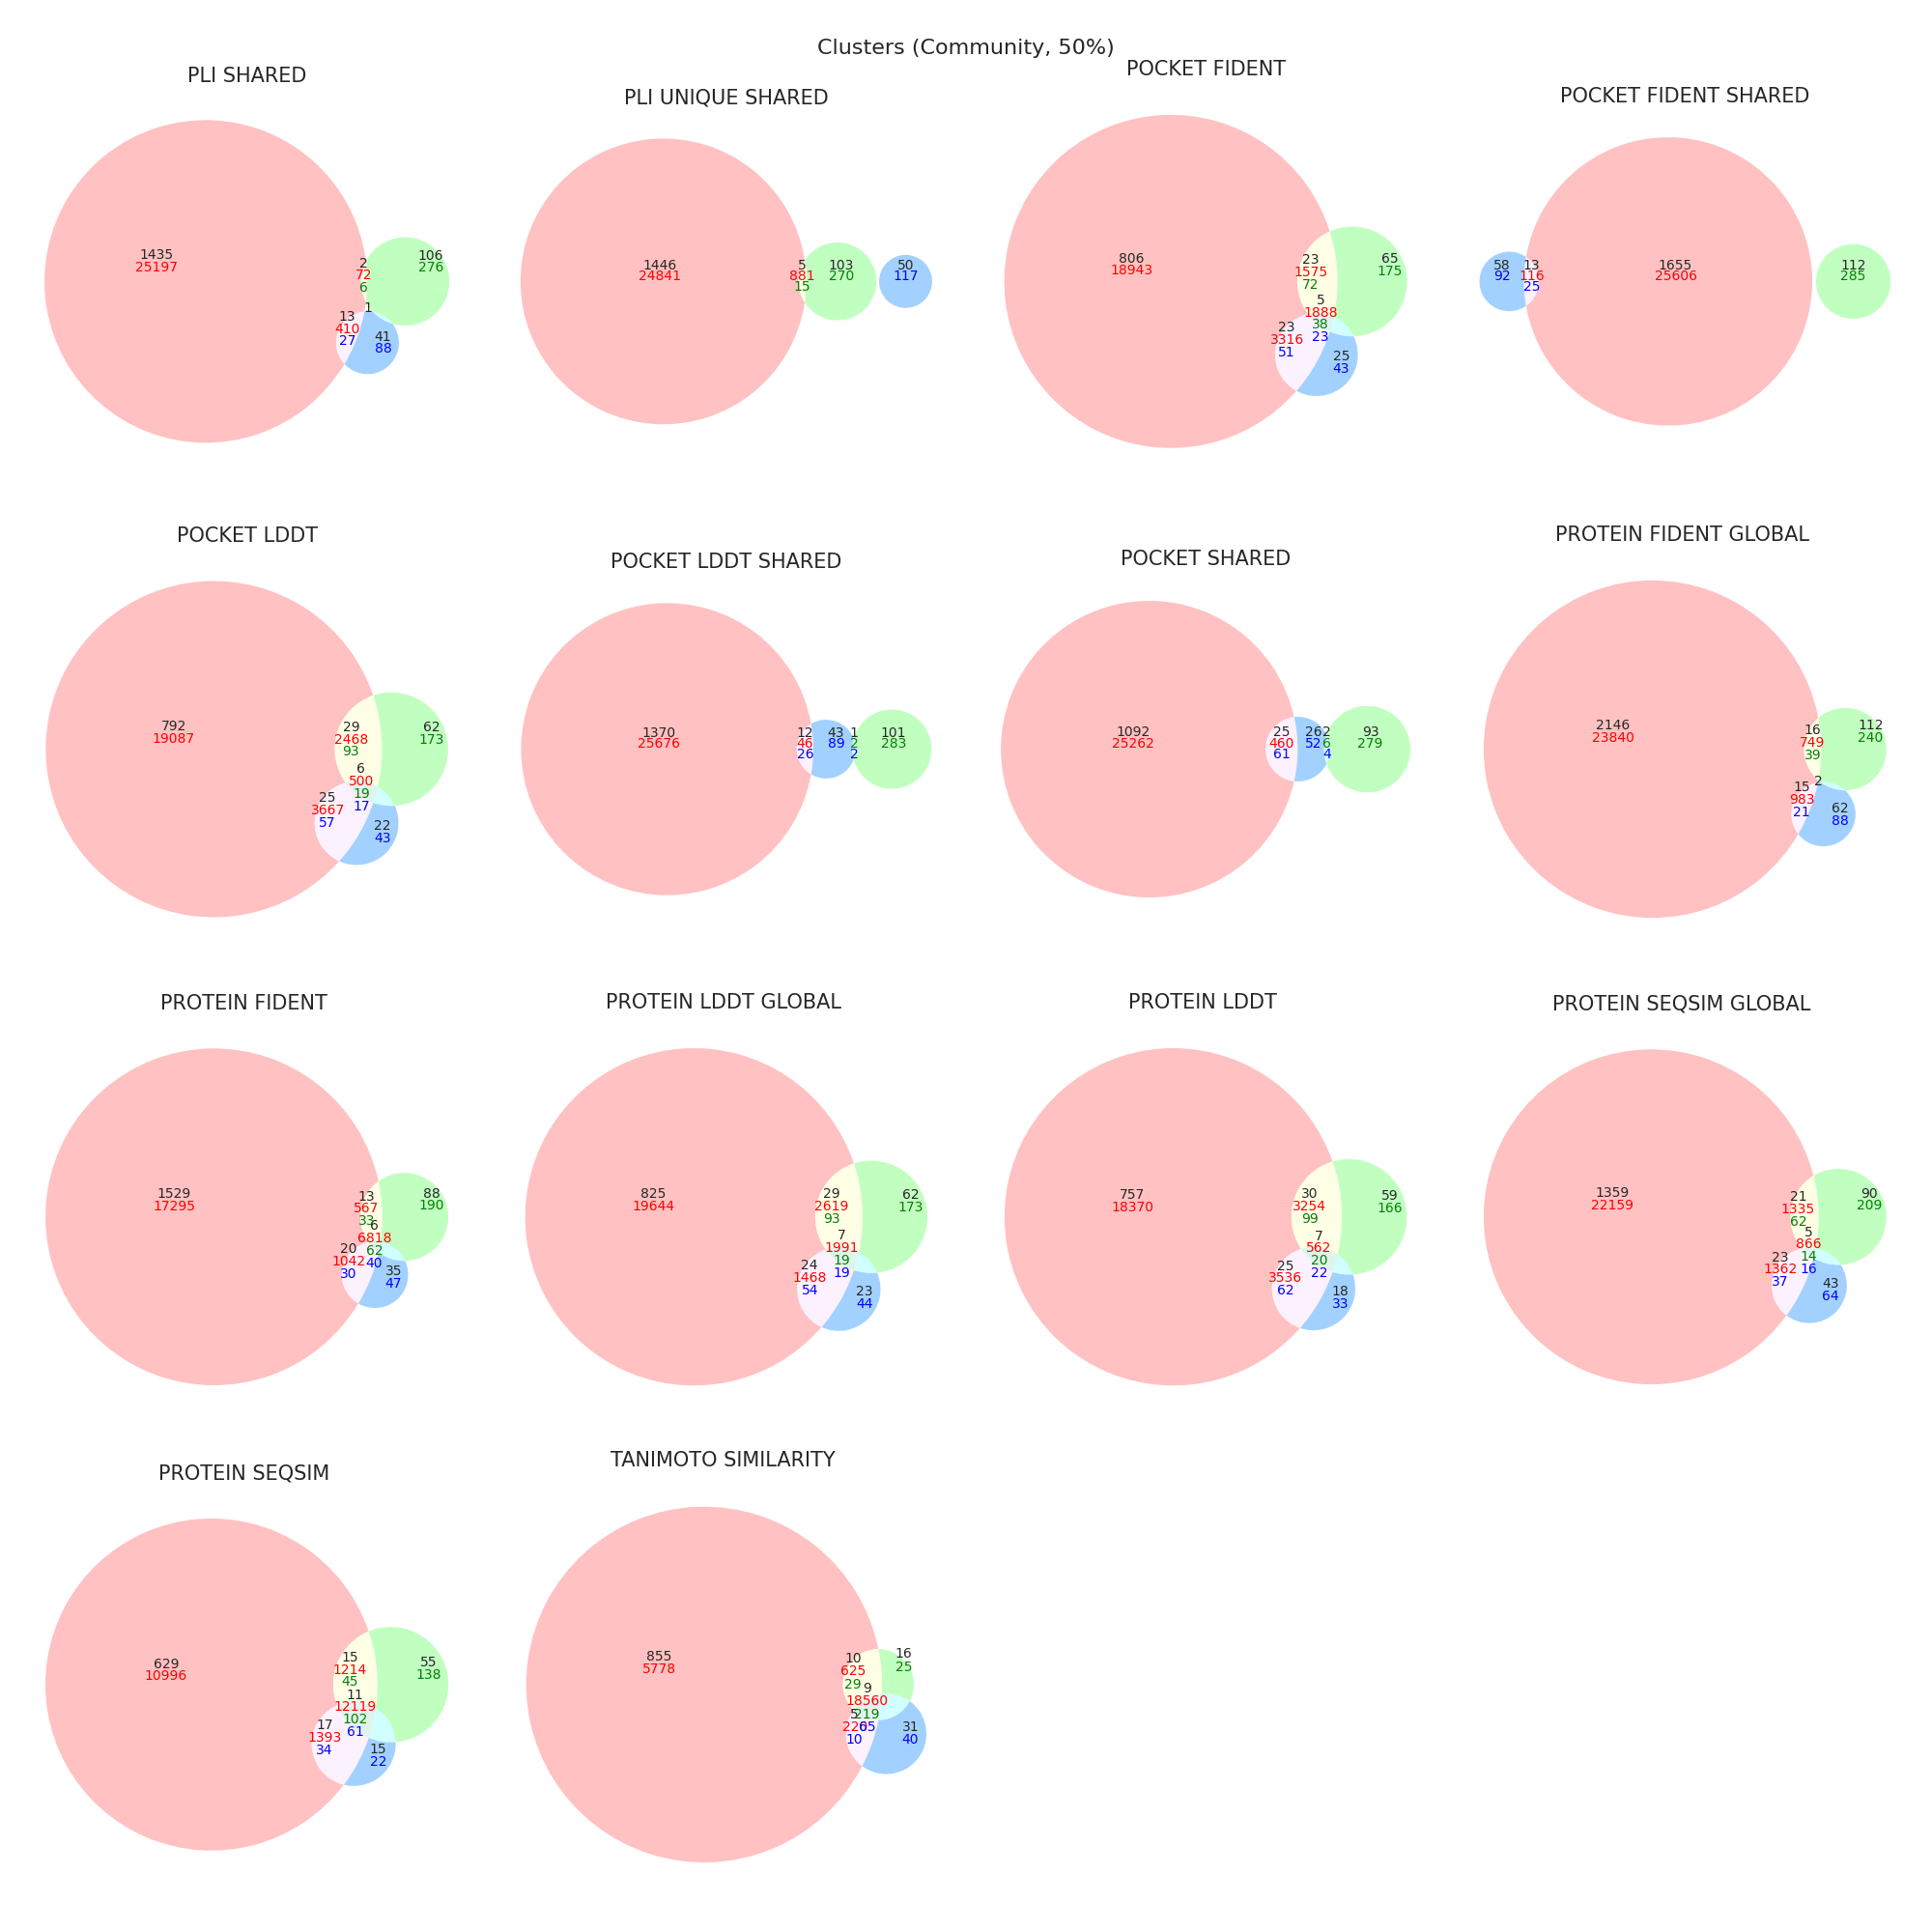